# Music Informatics Final Project: Song Transitions

1. **Feature extraction (Matej)** tempo, downbeats, key, energy, spectral flux, segmentation
2. **Tempo match & alignment (Bailin):** time-stretch song B to A's BPM, align downbeats, find overlap windows
3. **Transition scoring (Arvid):** score overlaps, pick best, apply crossfade, output the mix
4. **Evaluation & integration (Matei):** metrics, beat error, key distance, energy smoothness, listening, logging, report

1. **Feature extraction (Matej)** tempo, downbeats, key, energy, spectral flux, segmentation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import librosa, librosa.display
import scipy
import pickle
from scipy.io.wavfile import write

In [42]:
# Plot parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [43]:
def load_audio(path, sr=44100):
    """Load audio and return waveform + sample rate."""
    y, sr = librosa.load(path, sr=sr, mono=True)
    return y, sr


In [44]:
# Load the songs
path1 = 'under_pressure.mp3'
path2 = 'billie_jean.mp3'
path3 = 'get_lucky.mp3'
y_under_pressure, sr = load_audio(path1)
y_billie_jean, sr = load_audio(path2)
y_get_lucky, sr = load_audio(path3)


In [45]:
def get_tempo_baseline(y, sr):
    """
    Compute the tempo and beat locations. Returns the global tempo over the whole
    song and the location of beats.
    """
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    return tempo[0], beat_times

In [46]:
tempo_lib_1, beats_lib_1 = get_tempo_baseline(y_under_pressure, sr)
tempo_lib_2, beats_lib_2 = get_tempo_baseline(y_billie_jean, sr)
tempo_lib_3, beats_lib_3 = get_tempo_baseline(y_get_lucky, sr)

print(f"Tempo baseline: {tempo_lib_1:.1f} BPM, according to google should be ~112")
print(f"Tempo baseline: {tempo_lib_2:.1f} BPM, according to google should be ~117")
print(f"Tempo baseline: {tempo_lib_3:.1f} BPM, according to google should be ~116")

Tempo baseline: 114.8 BPM, according to google should be ~112
Tempo baseline: 117.5 BPM, according to google should be ~117
Tempo baseline: 114.8 BPM, according to google should be ~116


In [47]:
def plot_beats_zoom(y, sr, beat_times, tempo, start_time=0.0, duration=5.0, margin_ratio=0.2):
    """
    Plot song waveform and beat locations for a specified time window.
    """
    # Get the specified segment
    start_sample = int(start_time * sr)
    end_sample = int((start_time + duration) * sr)
    y_segment = y[start_sample:end_sample]

    # Only keep beats within this segment
    mask = (beat_times >= start_time) & (beat_times <= start_time + duration)
    beats_in_window = beat_times[mask]

    # Compute amplitude limits (for nicer plot so it dynamically scales)
    y_max = np.max(np.abs(y_segment))
    y_margin = y_max * margin_ratio
    ymin, ymax = -y_max - y_margin, y_max + y_margin

    # Plot
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y_segment, sr=sr, alpha=0.7)
    plt.vlines(beats_in_window - start_time, ymin=ymin, ymax=ymax,
               color='r', linestyle='--', alpha=0.8, label='Beats')
    plt.ylim(ymin, ymax)
    plt.title(f"Beat Tracking (Zoomed) — Tempo ≈ {tempo:.1f} BPM\n"
              f"Window: {start_time:.1f} – {start_time+duration:.1f} s")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

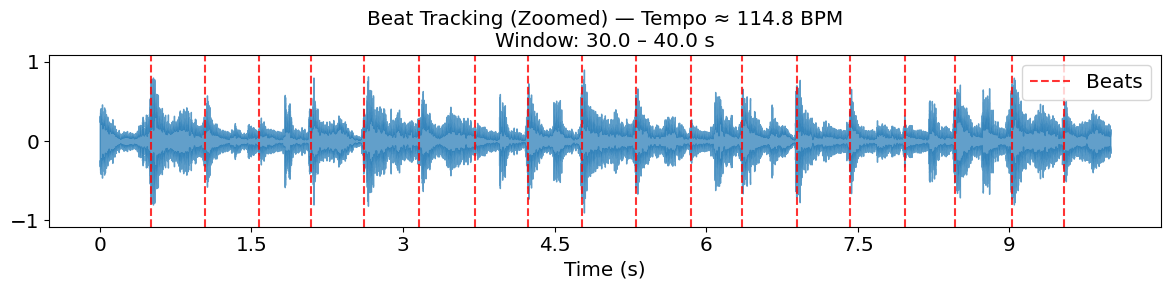

In [48]:
plot_beats_zoom(y_under_pressure, sr, beats_lib_1, tempo_lib_1, start_time=30, duration=10)

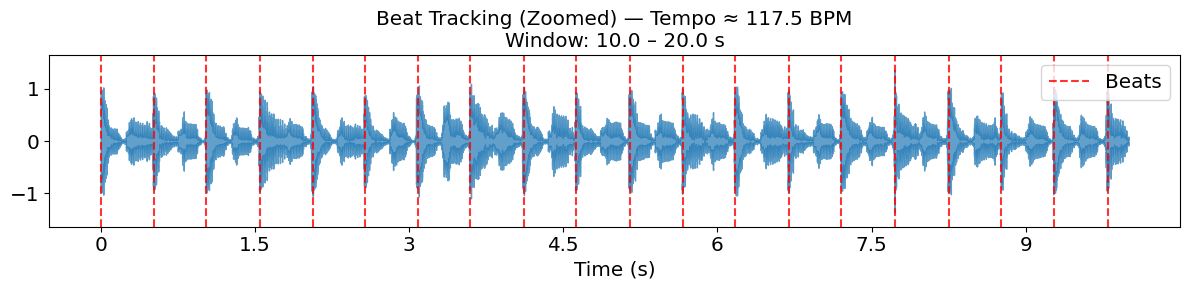

In [49]:
plot_beats_zoom(y_billie_jean, sr, beats_lib_2, tempo_lib_2, start_time=10, duration=10)

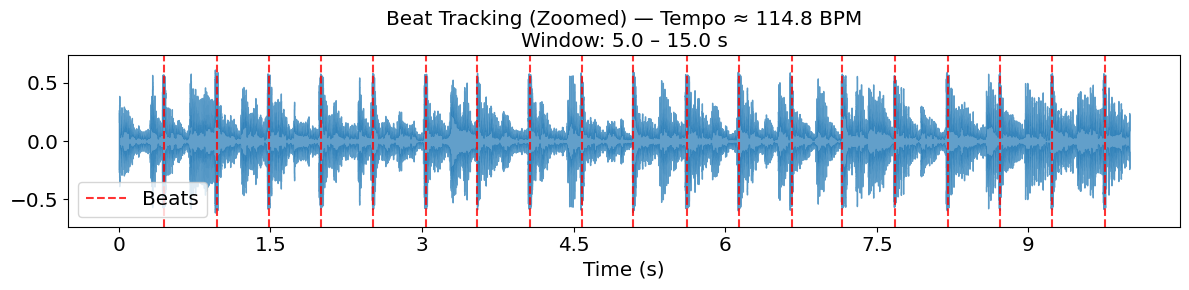

In [50]:
plot_beats_zoom(y_get_lucky, sr, beats_lib_3, tempo_lib_3, start_time=5, duration=10)

In [51]:
def get_downbeats_baseline(beat_times):
    """
    Get downbeats by assuming 4/4 time (same as paper) and the first beat is the '1'.
    """
    # Naive assumption: first beat is a downbeat. The paper uses a logistic regression classifier trained on manually annotated songs
    # to determine whether the first downbeat is on the first, second, third, or fourth beat.
    downbeat_times = beat_times[::4]
    return downbeat_times

Under Pressure: Found 457 beats and 115 downbeats.


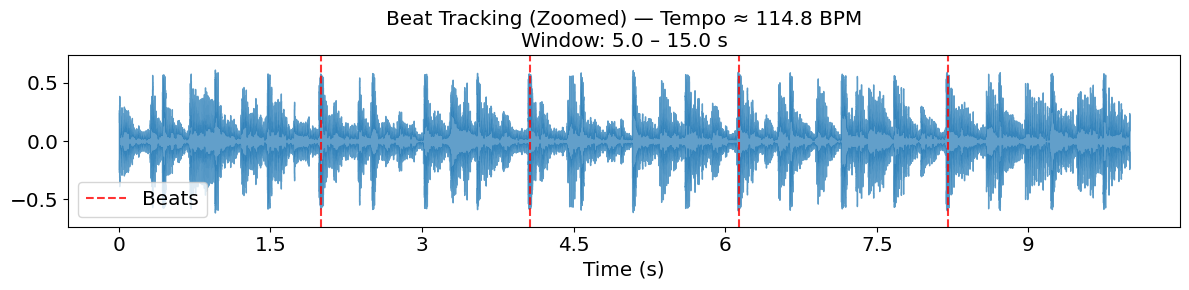

In [52]:
downbeats_lib_1 = get_downbeats_baseline(beats_lib_1)
downbeats_lib_2 = get_downbeats_baseline(beats_lib_2)
downbeats_lib_3 = get_downbeats_baseline(beats_lib_3)

print(f"Under Pressure: Found {len(beats_lib_1)} beats and {len(downbeats_lib_1)} downbeats.")
plot_beats_zoom(y_get_lucky, sr, downbeats_lib_3, tempo_lib_3, start_time=5, duration=10)

In [53]:
def get_key(y, sr):
    """
    Find the key of the song using chromagram
    """
    # Compute the chromagram
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    # Major/minor templates
    maj = np.array([1,0,0,0,1,0,0,1,0,0,0,0])
    min_ = np.array([1,0,0,1,0,0,0,1,0,0,1,0])
    labels = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    scores = []
    # Compute a correlation score for each key
    for i in range(12):
        scores.append(np.correlate(np.roll(maj, i), chroma_mean))
        scores.append(np.correlate(np.roll(min_, i), chroma_mean))
    best = np.argmax(scores)
    key_name = labels[best//2] + ('m' if best%2 else '')
    return key_name, float(np.max(scores))



In [54]:
# Key
key_pap, conf_pap = get_key(y_under_pressure, sr)
print(f"Key baseline Under Pressure: {key_pap} ({conf_pap:.2f}), according to google should be D major")

key_pap, conf_pap = get_key(y_billie_jean, sr)
print(f"Key baseline Billie Jean: {key_pap} ({conf_pap:.2f}), according to google should be F sharp minor")

key_pap, conf_pap = get_key(y_get_lucky, sr)
print(f"Key baseline Get Lucky: {key_pap} ({conf_pap:.2f}), according to google should be F sharp minor")

Key baseline Under Pressure: Em (2.20), according to google should be D major
Key baseline Billie Jean: F#m (2.15), according to google should be F sharp minor
Key baseline Get Lucky: Bm (2.58), according to google should be F sharp minor


In [55]:
def get_energy_baseline(y, sr, hop_length=512):
    """
    Compute the RMS energy, which represents the loudness.
    """
    rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
    times = librosa.times_like(rms, sr=sr)
    return times, rms

In [56]:
def plot_energy(times, energy, title="Energy (RMS over Time)", start_time=0.0, duration=30.0):
    """
    Plot energy (RMS) for a specified time window.
    """
    # Calculate end time
    end_time = start_time + duration

    # Get data only from the specified segment
    mask = (times >= start_time) & (times <= end_time)
    times_segment = times[mask]
    energy_segment = energy[mask]

    # Plot
    plt.figure()
    plt.plot(times_segment, energy_segment)
    plt.title(f"{title}\nWindow: {start_time:.1f} – {end_time:.1f} s")
    plt.xlabel("Time (s)")
    plt.ylabel("RMS Energy")
    plt.xlim(start_time, end_time)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

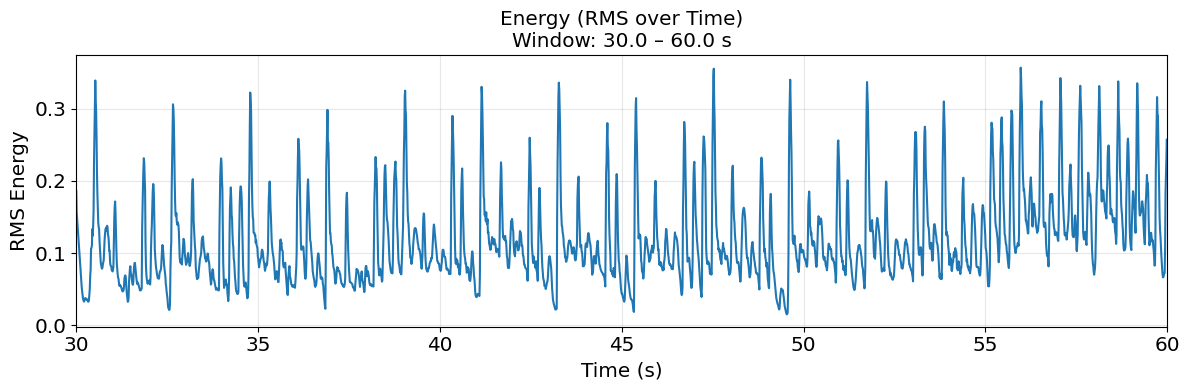

21423


In [57]:
t_e, rms = get_energy_baseline(y_under_pressure, sr)
plot_energy(t_e, rms, start_time=30)

print(len(t_e))

In [58]:
def get_spectral_flux_baseline(y, sr):
    """
    Compute the spectral flux using a melspectrogram.
    """
    # Use Melflux ODF
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, feature=librosa.feature.melspectrogram)
    times = librosa.times_like(onset_env, sr=sr)
    return onset_env, times

In [59]:
def plot_flux(times, flux, title="Spectral Flux", start_time=0.0, duration=30.0):
    """
    Plot spectral flux for a specified time window.
    """
    # Calculate end time
    end_time = start_time + duration

    # Get data only from the specified segment
    mask = (times >= start_time) & (times <= end_time)
    times_segment = times[mask]
    flux_segment = flux[mask]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(times_segment, flux_segment)
    plt.title(f"{title}\nWindow: {start_time:.1f} – {end_time:.1f} s")
    plt.xlabel("Time (s)")
    plt.ylabel("Flux (ΔSpectrum)")
    plt.xlim(start_time, end_time)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

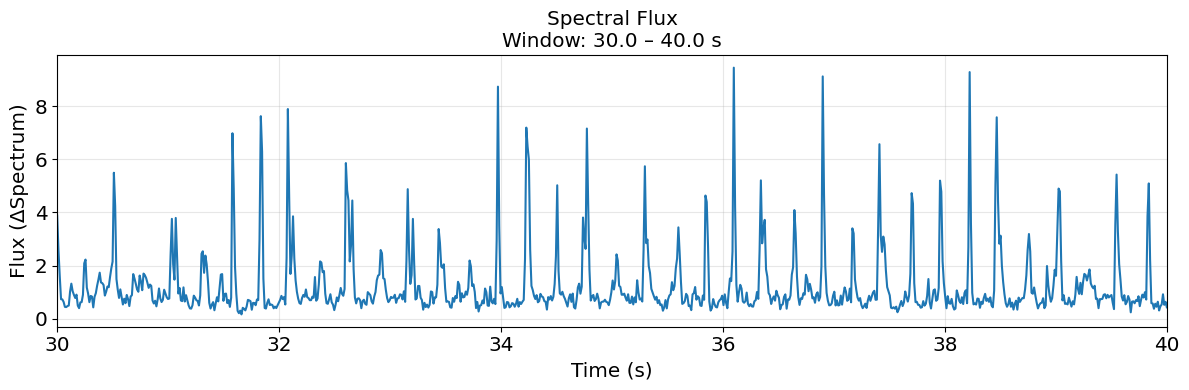

In [60]:
flux_1, flux_times_1 = get_spectral_flux_baseline(y_under_pressure, sr)
plot_flux(flux_times_1, flux_1, start_time=30, duration=10)

In [61]:
def get_segments_baseline(y, sr, hop_length=512):
    """
    Compute structural novelty curve and segment boundaries (baseline version).
    """
    # Step 1: Compute chroma
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)

    # Step 2: Build recurrence matrix (self-similarity)
    R = librosa.segment.recurrence_matrix(chroma, mode='affinity', sym=True)

    # Step 3: Gaussian blur for smoothing
    Rf = scipy.ndimage.gaussian_filter(R, sigma=1.0)

    # Step 4: Build kernel
    L = 16
    kernel = np.outer(np.concatenate([np.ones(L), -np.ones(L)]),
                      np.concatenate([-np.ones(L), np.ones(L)]))

    # Step 5: Compute novelty by 2D convolution along the diagonal
    novelty = np.zeros(Rf.shape[0])
    for i in range(L, Rf.shape[0]-L):
        novelty[i] = np.sum(Rf[i-L:i+L, i-L:i+L] * kernel)
    novelty = np.maximum(0, novelty)  # half-wave rectify

    # Step 6: Peak picking for boundaries
    peaks = librosa.util.peak_pick(novelty, pre_max=8, post_max=8,
                                   pre_avg=8, post_avg=8, delta=0.1, wait=10)
    boundaries = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)

    return boundaries, novelty

In [62]:
def plot_segments(novelty, boundaries, sr, hop_length=512, title="Structural Novelty"):
    """
    Plot structural novelty curve and segment boundaries.
    """
    times = librosa.frames_to_time(np.arange(len(novelty)), sr=sr, hop_length=hop_length)

    plt.figure()

    plt.plot(times, novelty, color='teal', alpha=0.7, label='Novelty curve')
    plt.vlines(boundaries, 0, np.max(novelty), color='r', linestyle='--', alpha=0.8, label='Segment boundaries')

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Novelty")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

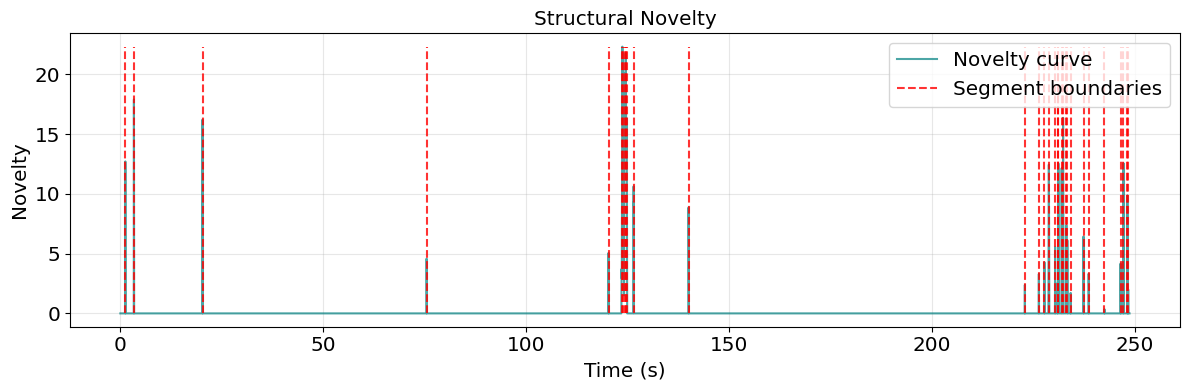

In [63]:
boundaries, novelty = get_segments_baseline(y_under_pressure, sr)
plot_segments(novelty, boundaries, sr)

In [64]:
def plot_segments_over_waveform(y, sr, boundary_times, title="Structural Segments"):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.7)
    plt.vlines(boundary_times, ymin=-1, ymax=1,
               color='r', linestyle='--', alpha=0.8, label='Segment boundaries')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

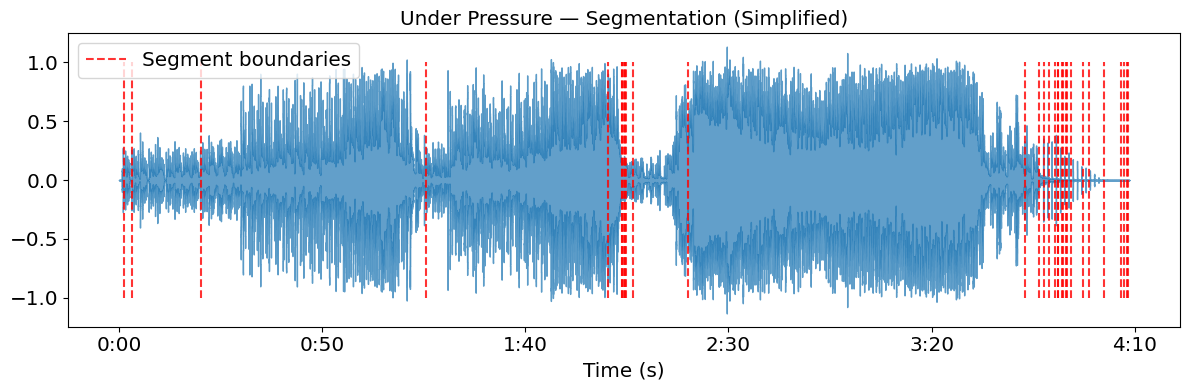

In [65]:
plot_segments_over_waveform(y_under_pressure, sr, boundaries, title="Under Pressure — Segmentation (Simplified)")

In [66]:
"""
Run all the code and all three songs (extend to more if we add them), store in dictionaries, save the dict. for quick retrieval
"""
print("Starting feature extraction for all songs...")

# All songs
audio_files = [
    ('Under Pressure', y_under_pressure),
    ('Billie Jean', y_billie_jean),
    ('Get Lucky', y_get_lucky)
]

song_library = []

# Loop through each song and extract all features
for name, y in audio_files:
    print(f"\nProcessing: {name}...")

    # 1. Tempo and Beats
    tempo, beat_times = get_tempo_baseline(y, sr)

    # 2. Downbeats
    downbeat_times = get_downbeats_baseline(beat_times)

    # 3. Key
    key, _ = get_key(y, sr)

    # 4. Energy (RMS)
    energy_values, energy_times = get_energy_baseline(y, sr)

    # 5. Spectral Flux
    flux_times, flux_values = get_spectral_flux_baseline(y, sr)

    # 6. Segmentation
    segment_boundaries, novelty_curve = get_segments_baseline(y, sr)

    # Create the dictionary for this song
    song_data = {
        'name': name,
        'y': y,
        'tempo': tempo,
        'beat_times': beat_times,
        'downbeat_times': downbeat_times,
        'key': key,
        'energy_values': energy_values,
        'energy_times': energy_times,
        'flux_values': flux_values,
        'flux_times': flux_times,
        'segment_boundaries': segment_boundaries,
        'novelty_curve': novelty_curve
    }

    song_library.append(song_data)

print("\nFeature extraction complete!")


# Save
filename = 'song_library.pkl'
with open(filename, 'wb') as f:
    pickle.dump(song_library, f)

Starting feature extraction for all songs...

Processing: Under Pressure...

Processing: Billie Jean...

Processing: Get Lucky...

Feature extraction complete!


Successfully loaded 3 songs from song_library.pkl

Loaded song name: Under Pressure
Loaded song tempo: 114.84375


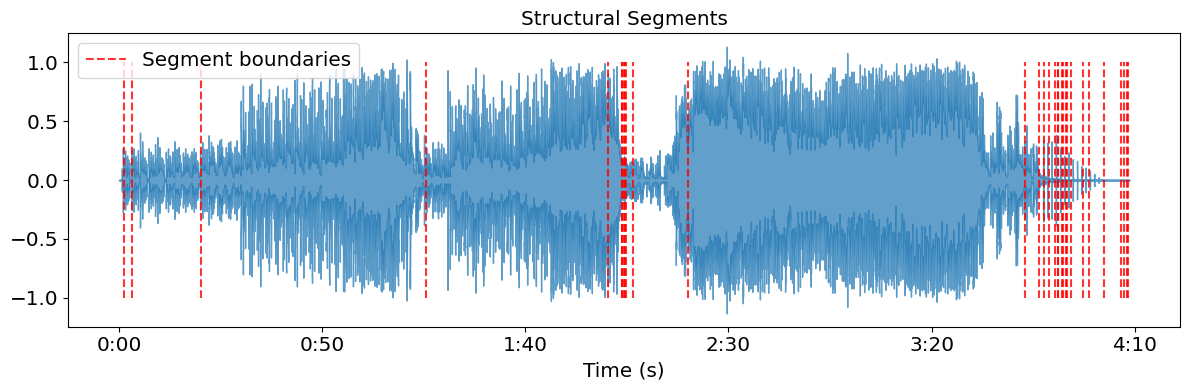

In [67]:
"""
If you have the song_library file, you can use this to load all the data so no need to run everythinh
Could be useful as the segmentation takes about a minute or two (which is not a lot but a bit annoying)
"""

filename = 'song_library.pkl'

# Open the file in 'read-binary' (rb) mode and load the data
with open(filename, 'rb') as f:
    loaded_song_library = pickle.load(f)

print(f"Successfully loaded {len(loaded_song_library)} songs from {filename}")

# E.g. use like this
song_a = loaded_song_library[0]
print(f"\nLoaded song name: {song_a['name']}")
print(f"Loaded song tempo: {song_a['tempo']}")

plot_segments_over_waveform(song_a['y'], sr, song_a['segment_boundaries'])

2. **Tempo match & alignment (Bailin):** time-stretch song B to A's BPM, align downbeats, find overlap window

In [ ]:
"""

def local_tempo(y, sr, center_s, window_s=12.0):

    a = max(0, int((center_s - window_s/2) * sr))
    b = min(len(y), int((center_s + window_s/2) * sr))
    y_win = y[a:b]
    onset = librosa.onset.onset_strength(y=y_win, sr=sr)
    if len(onset) < 4:
        t, _ = librosa.beat.beat_track(y=y_win, sr=sr)
        return float(t)
    tg = librosa.feature.tempogram(onset_envelope=onset, sr=sr)
    tempi = librosa.tempo_frequencies(tg.shape[0], sr=sr)
    curve = tempi[np.argmax(tg, axis=0)]
    return float(np.median(curve))
"""

def local_tempo(y, sr, center_s, window_s=12.0):
    """Median of tempogram peak tempi in a window around center_s"""
    a = max(0, int((center_s - window_s/2) * sr))
    b = min(len(y), int((center_s + window_s/2) * sr))
    if b <= a:
        return float('nan')

    y_win = y[a:b]

    onset = librosa.onset.onset_strength(y=y_win, sr=sr)
    if onset is None or len(onset) < 4:
        t, _ = librosa.beat.beat_track(y=y_win, sr=sr)
        return float(t) if np.isfinite(t) and t > 0 else float('nan')

    tg = librosa.feature.tempogram(onset_envelope=onset, sr=sr)
    if tg.size == 0:
        return float('nan')

    tempi = librosa.tempo_frequencies(tg.shape[0], sr=sr)
    curve = tempi[np.argmax(tg, axis=0)]
    val = float(np.median(curve))
    return val if np.isfinite(val) and val > 0 else float('nan')

In [69]:
# def start_time_A_20th_last_beat(beatsA, k=20):
#     """
#     beatsA: 1D np.array of beat times (seconds) for Track A
#     k:     how many beats before the end (default 20)
#     """
#     if beatsA is None or len(beatsA) == 0:
#         raise ValueError("No beats found for Track A.")
#     if len(beatsA) <= k:
#         return float(beatsA[0])
#     return float(beatsA[-k])

# def nearest_downbeat_at_or_before(t, downbeats, tol=0.08):
#     """
#     Return nearest downbeat <= t within 'tol' seconds; else None.
#     """
#     if downbeats is None or len(downbeats) == 0:
#         return None
#     idx = np.searchsorted(downbeats, t, side="right") - 1
#     if idx < 0:
#         return None
#     cand = float(downbeats[idx])
#     return cand if (t - cand) <= tol else None

# def start_time_A_20th_last_with_downbeat(beatsA, downbeatsA=None, k=20, snap_tol=0.08):
#     """
#     Pick the k-th last beat as the transition start and, if a downbeat is
#     at/just before that moment (within snap_tol), snap to that downbeat.
#     """
#     tA = start_time_A_20th_last_beat(beatsA, k=k)
#     db = nearest_downbeat_at_or_before(tA, downbeatsA, tol=snap_tol)
#     return float(db) if db is not None else float(tA)

# def split_track_A_for_transition(yA, sr, start_time_A, overlap_beats, beatsA):
#     """
#     Split Track A around the chosen transition start.

#     Returns:
#       A_pre      : samples before the transition start
#       A_overlap  : samples during the overlap window (length = overlap_beats)
#       A_after    : samples after the overlap window
#       end_time_A : end time (seconds) of the overlap window on A
#     """
#     # find beat index at/after start_time_A
#     i0 = np.searchsorted(beatsA, start_time_A)
#     # end index = i0 + overlap_beats (clamped)
#     i1 = min(i0 + overlap_beats, len(beatsA) - 1)


#     s0 = int(round(start_time_A * sr))
#     s1 = int(round(float(beatsA[i1])   * sr))
#     s0 = max(0, min(s0, len(yA)))
#     s1 = max(s0, min(s1, len(yA)))

#     A_pre     = yA[:s0]
#     A_overlap = yA[s0:s1]
#     A_after   = yA[s1:]
#     return A_pre, A_overlap, A_after, float(beatsA[i1])

In [70]:
# ---------- ENERGY MATCH + EQUAL-POWER CROSSFADE ----------

def _rms(x: np.ndarray) -> float:
    return float(np.sqrt(np.mean(np.square(x)) + 1e-12))

# def loudness_match_gain(A_overlap: np.ndarray, B_overlap: np.ndarray, sr: int, max_ref_seconds: float = 4.0) -> float:
#     """
#     Compute a gain to scale B so its loudness near the seam matches A.
#     Uses the last 'ref' window of A and the first 'ref' window of B.
#     """
#     if len(A_overlap) == 0 or len(B_overlap) == 0:
#         return 1.0
#     ref_samples = int(min(max_ref_seconds, 0.5 * len(A_overlap) / sr) * sr)  # <= 4s, but not more than half the overlap
#     ref_samples = max(ref_samples, int(0.25 * sr))  # ensure >= ~250 ms

#     A_ref = A_overlap[-ref_samples:] if len(A_overlap) >= ref_samples else A_overlap
#     B_ref = B_overlap[:ref_samples]  if len(B_overlap) >= ref_samples else B_overlap

#     rms_A = _rms(A_ref)
#     rms_B = _rms(B_ref)
#     return (rms_A / max(rms_B, 1e-9))

def equal_power_crossfade(A_overlap: np.ndarray, B_overlap: np.ndarray, sr: int) -> np.ndarray:
    n = min(len(A_overlap), len(B_overlap))
    if n == 0:
        return np.zeros(0, dtype=np.float32)

    a = A_overlap[:n].astype(np.float32, copy=False)
    b = B_overlap[:n].astype(np.float32, copy=False)

    t = np.linspace(0.0, 1.0, n, dtype=np.float32)
    gA = np.cos(0.5 * np.pi * t)     # 1 -> 0
    gB = np.sin(0.5 * np.pi * t)     # 0 -> 1
    mixed = gA * a + gB * b

    def _rms(x): return float(np.sqrt(np.mean(x * x) + 1e-12))
    ref = max(int(0.25 * sr), min(int(0.5 * n), int(0.5 * sr)))
    A_end_rms   = _rms(a[-ref:]) if len(a) >= ref else _rms(a)
    B_start_rms = _rms(b[:ref])  if len(b) >= ref else _rms(b)

    target = A_end_rms + (B_start_rms - A_end_rms) * t
    headroom = 10 ** (-0.7 / 20.0)
    lo = min(A_end_rms, B_start_rms)
    hi = max(A_end_rms, B_start_rms)
    target = np.clip(target, lo, hi) * headroom

    win = max(1, int(0.045 * sr))
    if win > 1:
        hann = np.hanning(win).astype(np.float32); hann /= hann.sum()
        cur = np.sqrt(np.convolve(mixed * mixed, hann, mode="same") + 1e-12)
    else:
        cur = np.full(n, _rms(mixed), dtype=np.float32)

    eps = 1e-9
    gain = target / np.maximum(cur, eps)
    gain = np.clip(gain, 0.70, 10 ** (0.8 / 20.0))

    alpha = 0.12
    g = np.empty_like(gain)
    acc = gain[0]
    for i in range(n):
        acc = alpha * gain[i] + (1 - alpha) * acc
        g[i] = acc
    acc = g[-1]
    for i in range(n - 1, -1, -1):
        acc = alpha * g[i] + (1 - alpha) * acc
        g[i] = acc

    return (mixed * g).astype(np.float32, copy=False)

# def energy_match_and_crossfade(A_overlap: np.ndarray, B_overlap: np.ndarray, sr: int) -> np.ndarray:
#     gain_B = loudness_match_gain(A_overlap, B_overlap, sr)
#     B_matched = B_overlap * gain_B
#     return equal_power_crossfade(A_overlap, B_matched)

In [71]:
# ---------- KEY / PITCH HELPERS ----------

_KEY_NAMES = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

_KEY_NAMES_MAP = {name: i for i, name in enumerate(_KEY_NAMES)}

def format_key(tonic: int, mode: str) -> str:
    return f"{_KEY_NAMES[int(tonic) % 12]} {mode}"

def semitone_diff_to_match(
    tonic_src: int, mode_src: str,
    tonic_tgt: int, mode_tgt: str,
    prefer_same_mode: bool = True
) -> int:
    """
    Smallest signed semitone shift to move src key center to tgt key center.
    If prefer_same_mode and modes match, just align tonics directly.
    If modes differ, still align pitch class (keeps harmonic proximity simple).
    Returned range is [-6, +6].
    """
    diff = (int(tonic_tgt) - int(tonic_src)) % 12
    if diff > 6: diff -= 12
    return int(diff)

def pitch_shift_B_to_A(
    yB: np.ndarray, sr: int,
    keyA_tonic: int, keyA_mode: str,
    keyB_tonic: int, keyB_mode: str,
    max_semitones: int = 3,
    prefer_same_mode: bool = True
):
    """
    Compute nearest semitone shift to align B's key center to A's.
    Shift only if |n_steps| <= max_semitones.
    Returns: (yB_shifted, n_steps_applied, keyA_str, keyB_str)
    """
    keyA_str = format_key(keyA_tonic, keyA_mode)
    keyB_str = format_key(keyB_tonic, keyB_mode)

    n_steps = semitone_diff_to_match(keyB_tonic, keyB_mode, keyA_tonic, keyA_mode, prefer_same_mode)
    if abs(n_steps) > max_semitones:
        # too large: skip to avoid quality loss
        return yB, 0, keyA_str, keyB_str

    if n_steps == 0:
        return yB, 0, keyA_str, keyB_str

    yB_shifted = librosa.effects.pitch_shift(yB, sr=sr, n_steps=float(n_steps))
    return yB_shifted, int(n_steps), keyA_str, keyB_str

In [ ]:
def loudness_match_gain_A_to_B(A_overlap: np.ndarray, B_overlap: np.ndarray, sr: int, max_ref_seconds: float = 4.0) -> float:
    """
    Compute a gain to scale **A** so its loudness near the seam matches **B**.
    Uses the last window of A and the first window of B. B is left untouched.
    """
    if len(A_overlap) == 0 or len(B_overlap) == 0:
        return 1.0

    ref_samples = int(min(max_ref_seconds, 0.5 * len(A_overlap) / sr) * sr)
    ref_samples = max(ref_samples, int(0.25 * sr))

    A_ref = A_overlap[-ref_samples:] if len(A_overlap) >= ref_samples else A_overlap
    B_ref = B_overlap[:ref_samples]  if len(B_overlap) >= ref_samples else B_overlap

    try:
        rms_A = _rms(A_ref)
        rms_B = _rms(B_ref)
    except NameError:
        def _rms(x: np.ndarray) -> float:
            return float(np.sqrt(np.mean(np.square(x)) + 1e-12))
        rms_A = _rms(A_ref)
        rms_B = _rms(B_ref)

    return min(rms_B / max(rms_A, 1e-9), 1.0)


def pitch_shift_A_to_B(
    yA: np.ndarray, sr: int,
    keyA_tonic: int, keyA_mode: str,
    keyB_tonic: int, keyB_mode: str,
    max_semitones: int = 3,
    prefer_same_mode: bool = True
):
    n_steps = semitone_diff_to_match(keyA_tonic, keyA_mode, keyB_tonic, keyB_mode, prefer_same_mode)
    if abs(n_steps) == 0 or abs(n_steps) > max_semitones:
        return yA, 0
    yA_shifted = librosa.effects.pitch_shift(yA, sr=sr, n_steps=float(n_steps))
    return yA_shifted, int(n_steps)

In [73]:
# 1. MATCH TEMPO
# ratio = get_tempo_baseline(y_A) / get_tempo_baseline(y_B)
# librosa.effects.time_stretch(y_A, ratio)

# 2. START NEW SONG AT 20TH LAST BEAT OF FIRST SONG
# 20

# 3. MATCH ENERGY
# crossfade A into B


# 4. MATCH PITCH
# (EITHER LIBROSA)
# https://librosa.org/doc/0.11.0/generated/librosa.effects.pitch_shift.html

# (OR TORCH)
# https://pypi.org/project/torch-pitch-shift/#
# https://kentonishi.com/torch-pitch-shift/usage/

3. **Transition scoring (Arvid):** generate outputs, evaluation.

In [74]:
# Compare transition positions between A and B
# Rate each position by beat offset/key/energy
# Pick best position, match loudness, apply crossfade, save to WAV/MP3

In [75]:
def parse_key_string(key_str):
    """
    Parses a key string into tonic (INT) and mode (STR)
    """
    key_str = key_str.strip()
    if key_str.endswith('m'):
        tonic_str = key_str[:-1]
        mode = 'minor'
    else:
        tonic_str = key_str
        mode = 'major'

    tonic_int = _KEY_NAMES_MAP.get(tonic_str, 0)
    return tonic_int, mode

In [76]:
def candidate_transitions(songA, songB, sr, overlap_beats=8, num_downbeats=5):
    """
    Generate candidate transition positions between A and B.
    Prioritizes structural intros/outros if segmentation is available.
    Falls back to first/last N downbeats if structural segments are empty.

    Returns: List of tuples (tA_start, tB_start) of transition times
    """
    downbeats_A = songA['downbeat_times']
    downbeats_B = songB['downbeat_times']

    candidates_A = []
    candidates_B = []

    if 'segment_boundaries' in songA and len(songA['segment_boundaries']) > 0:
        outro_start_time = songA['segment_boundaries'][-1]
        candidates_A = downbeats_A[downbeats_A >= outro_start_time]

    if 'segment_boundaries' in songB and len(songB['segment_boundaries']) > 0:
        intro_end_time = songB['segment_boundaries'][0]
        candidates_B = downbeats_B[downbeats_B < intro_end_time]


    if len(candidates_A) == 0:
        print(f"Warning: No structural outro downbeats found for {songA['name']}. Using last {num_downbeats} downbeats as fallback.")
        num_A = min(num_downbeats, len(downbeats_A))
        candidates_A = downbeats_A[-num_A:]


    if len(candidates_B) == 0:
        print(f"Warning: No structural intro downbeats found for {songB['name']}. Using first {num_downbeats} downbeats as fallback.")
        num_B = min(num_downbeats, len(downbeats_B))
        candidates_B = downbeats_B[:num_B]

    candidates = []
    for tA in candidates_A:
        for tB in candidates_B:
            candidates.append((tA, tB))

    return candidates


In [77]:
def rate_transition(songA, songB, tA, tB, sr, overlap_beats=16, silence_threshold=0.01):
    """
    Rates a transition based on key, energy, and rhythmic similarity (DTW).
    """
    beatsA = songA['beat_times']
    beatsB = songB['beat_times']

    tA_idx = np.argmin(abs(beatsA - tA))
    tB_idx = np.argmin(abs(beatsB - tB))

    if songA['key'] == songB['key']:
      key_diff = 0
    else:
      key_diff = 1

    # Find the end of the overlap window
    tA_end_idx = min(tA_idx + overlap_beats, len(beatsA) - 1)
    tB_end_idx = min(tB_idx + overlap_beats, len(beatsB) - 1)

    # Get the ODF (flux) times
    flux_times_A = songA['flux_times']
    flux_times_B = songB['flux_times']

    # Find the start/end times of the overlap in seconds
    tA_start_s = beatsA[tA_idx]
    tA_end_s   = beatsA[tA_end_idx]
    tB_start_s = beatsB[tB_idx]
    tB_end_s   = beatsB[tB_end_idx]

    # Find the ODF values within that time window
    odf_A_indices = (flux_times_A >= tA_start_s) & (flux_times_A < tA_end_s)
    odf_B_indices = (flux_times_B >= tB_start_s) & (flux_times_B < tB_end_s)

    odf_A_segment = songA['flux_values'][odf_A_indices]
    odf_B_segment = songB['flux_values'][odf_B_indices]

    if len(odf_A_segment) == 0 or len(odf_B_segment) == 0:
        return float('inf')

    # Normalize the ODF segments
    odf_A_norm = (odf_A_segment - np.mean(odf_A_segment)) / np.std(odf_A_segment)
    odf_B_norm = (odf_B_segment - np.mean(odf_B_segment)) / np.std(odf_B_segment)

    # Calculate rhythmic distance using DTW
    D, wp = librosa.sequence.dtw(X=odf_A_norm, Y=odf_B_norm, metric='euclidean')
    rhythmic_diff = D[wp[-1, 0], wp[-1, 1]] / len(wp)

    # Final Weighted Score
    score = (key_diff * 2) + (rhythmic_diff * 1.0)

    return score

In [78]:
def find_best_transition(songA, songB, sr, num_downbeats=5):
    """
    Evaluate candidate transitions and return the best one.
    """
    candidates = candidate_transitions(songA, songB, sr, num_downbeats=num_downbeats)

    scored = []
    for (tA, tB) in candidates:
        score = rate_transition(songA, songB, tA, tB, sr)
        scored.append((score, tA, tB))

    # Sort candidates by score
    scored.sort(key=lambda x: x[0])

    # Choose the best one
    best_score, best_tA, best_tB = scored[0]

    return best_tA, best_tB

In [79]:
def make_transition(songA, songB, sr, overlap_beats=8):
    print(f"Starting transition A to B: {songA['name']} → {songB['name']}")

    yA = np.asarray(songA['y'])
    yB = np.asarray(songB['y'])

    # Anchor points
    best_tA, best_tB = find_best_transition(songA, songB, sr)
    print(f"Found best anchor points: tA={best_tA:.2f}s, tB={best_tB:.2f}s")

    # Get beat times
    beatsA = songA['beat_times']
    beatsB = songB['beat_times']

    # A
    iA0 = int(np.searchsorted(beatsA, best_tA))
    iA1 = min(iA0 + overlap_beats, len(beatsA) - 1)
    tA0 = float(best_tA)
    tA1 = float(beatsA[iA1])

    # B
    iB0 = int(np.searchsorted(beatsB, best_tB))
    iB1 = min(iB0 + overlap_beats, len(beatsB) - 1)
    tB0 = float(best_tB)
    tB1 = float(beatsB[iB1])

    # Slice audio
    sA0, sA1 = int(round(tA0 * sr)), int(round(tA1 * sr))
    sB0, sB1 = int(round(tB0 * sr)), int(round(tB1 * sr))
    A_pre      = yA[:sA0]
    A_overlap0 = yA[sA0:sA1]
    B_overlap  = yB[sB0:sB1]

    if len(A_overlap0) == 0 or len(B_overlap) == 0:
        print("Warning: empty overlap window")
        return np.concatenate([A_pre, yB[sB0:]])

    # Tempo-match A's overlap to B's overlap
    dur_A = len(A_overlap0) / sr
    dur_B = len(B_overlap)  / sr

    rate = (dur_A / max(dur_B, 1e-9))
    A_overlap = librosa.effects.time_stretch(A_overlap0, rate=float(rate))

    # Trim or pad A_overlap to match B_overlap length
    n = len(B_overlap)
    if len(A_overlap) > n:
        A_overlap = A_overlap[:n]
    elif len(A_overlap) < n:
        A_overlap = np.pad(A_overlap, (0, n - len(A_overlap)))

    # Pitch-shift A toward B
    keyA_tonic, keyA_mode = parse_key_string(songA['key'])
    keyB_tonic, keyB_mode = parse_key_string(songB['key'])
    A_overlap, n_steps = pitch_shift_A_to_B(
        A_overlap, sr, keyA_tonic, keyA_mode, keyB_tonic, keyB_mode
    )
    if n_steps != 0:
        print(f"Pitch-shifted A by {n_steps:+d} semitones toward B during overlap.")

    # Loudness-match A to B
    gain_A = loudness_match_gain_A_to_B(A_overlap, B_overlap, sr)
    A_overlap_matched = A_overlap * gain_A

    # Equal-power crossfade
    #mixed_overlap = equal_power_crossfade(A_overlap_matched, B_overlap)
    mixed_overlap = equal_power_crossfade(A_overlap_matched, B_overlap, sr)

    # Final assembly
    B_post = yB[sB1:]
    full_mix = np.concatenate([A_pre, mixed_overlap, B_post])

    # Normalize to avoid clipping
    peak = np.max(np.abs(full_mix))
    if peak > 0:
        full_mix = 0.98 * (full_mix / peak)

    print("Transition complete (A morphed into B; B unchanged outside overlap).")
    return full_mix

In [ ]:
def save_mix(y, sr, filename="mix.wav"):
    peak = np.max(np.abs(y)) + 1e-12
    y = 0.89 * (y / peak)
    y16 = np.int16(y * 32767)
    # y16 = np.int16(y / np.max(np.abs(y)) * 32767)
    write(filename, sr, y16)
    print(f"Saved mix to {filename}")

song_A = loaded_song_library[1]
song_B = loaded_song_library[2]

mix = make_transition(song_A, song_B, sr, overlap_beats=16)
save_mix(mix, sr, "final_output.wav")

Starting transition A to B: Billie Jean → Get Lucky
Found best anchor points: tA=169.89s, tB=0.79s
Transition complete (A morphed into B; B unchanged outside overlap).
Saved mix to final_output.wav


4. **Evaluation & integration (Matei):** evaluation, logging, report

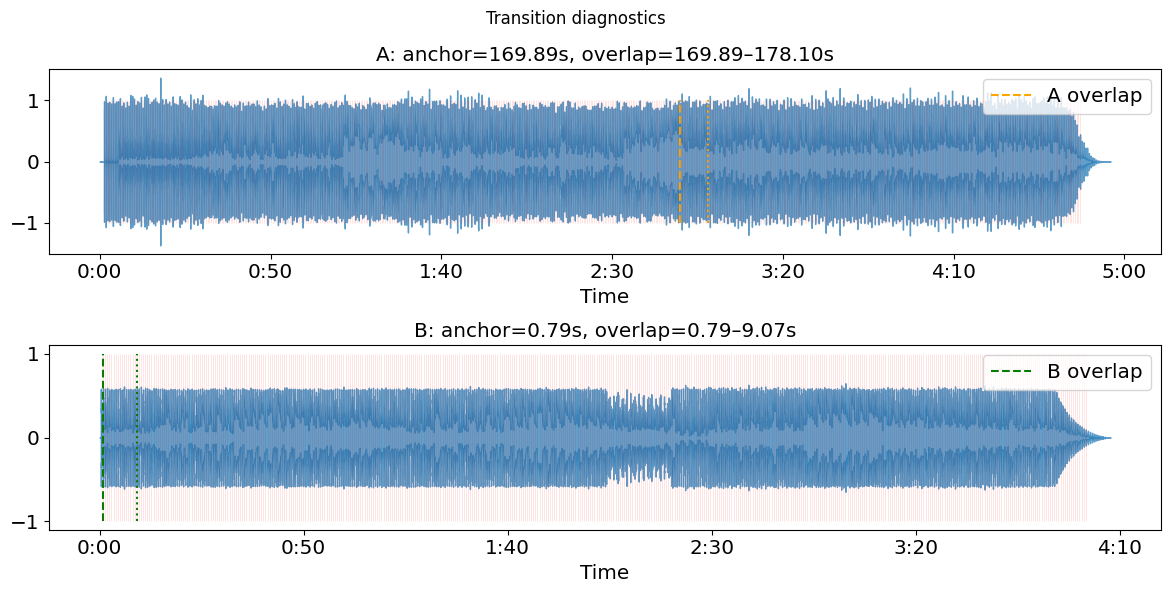

In [ ]:
def visualize_transition(songA, songB, sr, best_tA, best_tB, overlap_beats, title="Transition diagnostics"):
    yA = np.asarray(songA['y']); yB = np.asarray(songB['y'])
    beatsA = songA['beat_times']; beatsB = songB['beat_times']

    iA0 = int(np.searchsorted(beatsA, best_tA))
    iB0 = int(np.searchsorted(beatsB, best_tB))
    iA1 = min(iA0 + overlap_beats, len(beatsA) - 1)
    iB1 = min(iB0 + overlap_beats, len(beatsB) - 1)

    tA0, tA1 = float(best_tA), float(beatsA[iA1])
    tB0, tB1 = float(best_tB), float(beatsB[iB1])

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
    ax = axes[0]
    librosa.display.waveshow(yA, sr=sr, alpha=0.7, ax=ax)
    ax.vlines([tA0, tA1], ymin=-1, ymax=1, colors=['orange','orange'], linestyles=['--',':'], label='A overlap')
    ax.vlines(beatsA, ymin=-1, ymax=1, color='r', alpha=0.15, linewidth=0.5)
    ax.set_title(f"A: anchor={tA0:.2f}s, overlap={tA0:.2f}–{tA1:.2f}s")
    ax.legend(loc='upper right')

    ax = axes[1]
    librosa.display.waveshow(yB, sr=sr, alpha=0.7, ax=ax)
    ax.vlines([tB0, tB1], ymin=-1, ymax=1, colors=['green','green'], linestyles=['--',':'], label='B overlap')
    ax.vlines(beatsB, ymin=-1, ymax=1, color='r', alpha=0.15, linewidth=0.5)
    ax.set_title(f"B: anchor={tB0:.2f}s, overlap={tB0:.2f}–{tB1:.2f}s")
    ax.legend(loc='upper right')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

best_tA, best_tB = find_best_transition(song_A, song_B, sr)
visualize_transition(song_A, song_B, sr, best_tA, best_tB, overlap_beats=16)

Resources:
https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-018-0134-8

In [ ]:
def _rms(x): return float(np.sqrt(np.mean(x*x) + 1e-12))

def beat_phase_error(t, beat_times):
    i = int(np.searchsorted(beat_times, t))
    i0 = max(i-1, 0)
    if i0+1 >= len(beat_times): return 0.0
    period = beat_times[i0+1] - beat_times[i0]
    if period <= 0: return 0.0
    phase = (t - beat_times[i0]) / period
    return min(phase, 1.0 - phase)

def window_rms(y, sr, t0, dur=0.75):
    a = max(0, int(t0 * sr))
    b = min(len(y), int((t0 + dur) * sr))
    seg = y[a:b]
    return _rms(seg) if len(seg) else 0.0

def semitone_distance_from_keys(keyA_str, keyB_str, key_map={'C':0,'C#':1,'D':2,'D#':3,'E':4,'F':5,'F#':6,'G':7,'G#':8,'A':9,'A#':10,'B':11}):
    def parse(k):
        k = k.strip()
        minor = k.endswith('m')
        tonic = k[:-1] if minor else k
        return key_map.get(tonic, 0), ('minor' if minor else 'major')
    tA, mA = parse(keyA_str); tB, mB = parse(keyB_str)
    d = abs((tA - tB) % 12); d = min(d, 12 - d)
    return d, (mA == mB)

def evaluate_transition(songA, songB, sr, best_tA, best_tB, overlap_beats=16):
    yA = np.asarray(songA['y']); yB = np.asarray(songB['y'])
    beatsA = songA['beat_times']; beatsB = songB['beat_times']

    # Timing window edges
    iA0 = int(np.searchsorted(beatsA, best_tA)); iB0 = int(np.searchsorted(beatsB, best_tB))
    iA1 = min(iA0 + overlap_beats, len(beatsA) - 1)
    iB1 = min(iB0 + overlap_beats, len(beatsB) - 1)
    tA0, tA1 = float(best_tA), float(beatsA[iA1])
    tB0, tB1 = float(best_tB), float(beatsB[iB1])

    # 1) Beat-phase alignment
    phase_err = abs(beat_phase_error(best_tA, beatsA) - beat_phase_error(best_tB, beatsB))

    # 2) Loudness continuity
    eA_tail = window_rms(yA, sr, tA0 - 0.5, 0.5)
    eA_ovlp = window_rms(yA, sr, tA0, 0.5)
    eB_head = window_rms(yB, sr, tB0, 0.5)

    # 3) Loudness overlap range
    lo, hi = 0.90*min(eA_tail, eB_head), 1.05*max(eA_tail, eB_head)

    # 4) Harmony distance
    semis, same_mode = semitone_distance_from_keys(songA['key'], songB['key'])

    # 5) Tempo continuity
    def local_tempo(y, sr, center_s, window_s=8.0):
        a = max(0, int((center_s - window_s/2) * sr))
        b = min(len(y), int((center_s + window_s/2) * sr))
        if b <= a: return np.nan
        onset = librosa.onset.onset_strength(y=y[a:b], sr=sr)
        if onset is None or len(onset) < 4:
            t, _ = librosa.beat.beat_track(y=y[a:b], sr=sr)
            return float(t) if np.isfinite(t) and t > 0 else np.nan
        tg = librosa.feature.tempogram(onset_envelope=onset, sr=sr)
        tempi = librosa.tempo_frequencies(tg.shape[0], sr=sr)
        curve = tempi[np.argmax(tg, axis=0)]
        val = float(np.median(curve))
        return val if np.isfinite(val) and val > 0 else np.nan

    tempoA_local = local_tempo(yA, sr, best_tA)
    tempoB_local = local_tempo(yB, sr, best_tB)
    tempo_err = abs(tempoA_local - tempoB_local) if np.isfinite(tempoA_local) and np.isfinite(tempoB_local) else np.nan

    report = {
        "anchor_A_seconds": round(best_tA, 3),
        "anchor_B_seconds": round(best_tB, 3),
        "phase_error_beats(0..0.5)": round(phase_err, 3),
        "A_tail_RMS": round(eA_tail, 6),
        "B_head_RMS": round(eB_head, 6),
        "target_overlap_RMS_range": [round(lo, 6), round(hi, 6)],
        "key_distance_semitones(0..6)": semis,
        "same_mode": bool(same_mode),
        "tempoA_local_BPM": None if not np.isfinite(tempoA_local) else round(tempoA_local, 2),
        "tempoB_local_BPM": None if not np.isfinite(tempoB_local) else round(tempoB_local, 2),
        "tempo_error_BPM": None if not np.isfinite(tempo_err) else round(tempo_err, 2)
    }
    return report

best_tA, best_tB = find_best_transition(song_A, song_B, sr)
report = evaluate_transition(song_A, song_B, sr, best_tA, best_tB, overlap_beats=16)
report

{'anchor_A_seconds': np.float64(169.889),
 'anchor_B_seconds': np.float64(0.789),
 'phase_error_beats(0..0.5)': np.float64(0.0),
 'A_tail_RMS': 0.265632,
 'B_head_RMS': 0.136536,
 'target_overlap_RMS_range': [0.122882, 0.278914],
 'key_distance_semitones(0..6)': 5,
 'same_mode': True,
 'tempoA_local_BPM': None,
 'tempoB_local_BPM': None,
 'tempo_error_BPM': None}

In [85]:
def judge(report):
    notes = []
    ok = True

    # Phase
    if report["phase_error_beats(0..0.5)"] > 0.12:
        ok = False
        notes.append("Beat-phase misaligned (>0.12).")

    # Loudness band
    lo, hi = report["target_overlap_RMS_range"]
    if (hi / max(lo, 1e-9)) > 1.6:
        notes.append("Large loudness mismatch (>4 dB).")

    # Key distance
    if report["key_distance_semitones(0..6)"] >= 4:
        notes.append("Keys are far apart (>=4 semitones).")

    # Tempo error
    te = report["tempo_error_BPM"]
    if te is not None and te > 3.0:
        ok = False
        notes.append(f"Local tempo mismatch is {te:.1f} BPM.")

    verdict = "PASS" if ok else "CHECK"
    return verdict, notes

verdict, notes = judge(report)
print("Test:", verdict)
for n in notes:
    print("-", n)

Test: PASS
- Large loudness mismatch (>4 dB).
- Keys are far apart (>=4 semitones).
